Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libjemalloc2 liblua5.1-0 liblzf1 lua-bitop lua-cjson redis-tools
Suggested packages:
  ruby-redis
The following NEW packages will be installed:
  libjemalloc2 liblua5.1-0 liblzf1 lua-bitop lua-cjson redis-server redis-tools
0 upgraded, 7 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,273 kB of archives.
After this operation, 5,725 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libjemalloc2 amd64 5.2.1-4ubuntu1 [240 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 liblua5.1-0 amd64 5.1.5-8.1build4 [99.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 liblzf1 amd64 3.6-3 [7,444 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 lua-bitop amd64 1.0.2-5 [6,680 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 lua-c

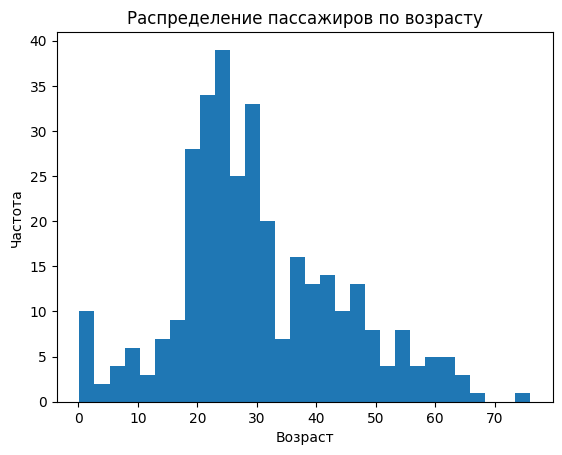

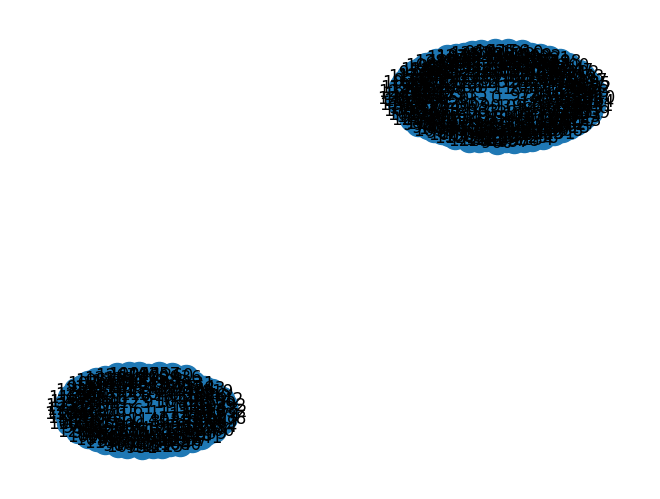

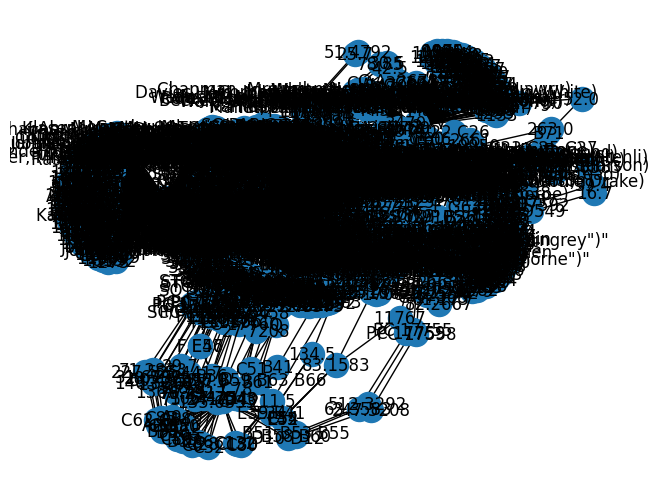

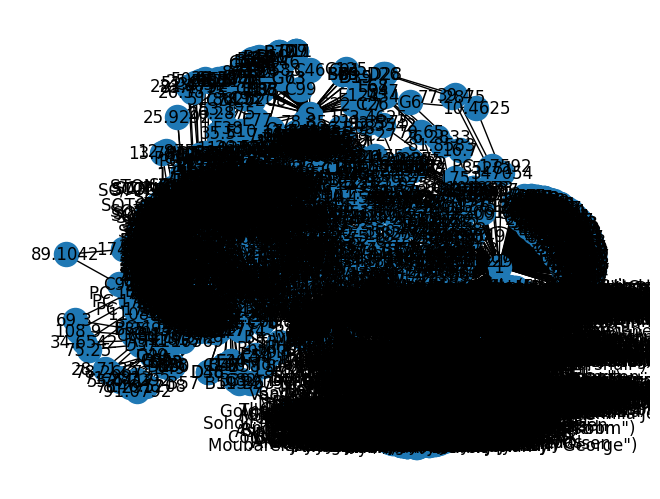

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
   PassengerId  Survived  P

In [1]:
!apt-get install redis-server
!pip install redis

import pandas as pd
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt
import redis
import os


# Представление df в виде графа
def printGraph(df):
    # Преобразуем датафрейм в словарь
    data_dict = dict(df.iterrows())
    # Создаем граф
    G = nx.Graph()
    # Добавляем вершины и ребра
    for key, value in data_dict.items():
        G.add_nodes_from(value)
        for i in range(len(value) - 1):
            G.add_edge(value.iloc[i], value.iloc[i + 1])
    # Рисуем граф
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()


# Тестовые запросы для реляционной базы данных
relational_db_slct_to_gender = "SELECT * FROM GENDER WHERE Survived = '1' LIMIT 10"
relational_db_select_to_test = "SELECT Name, Age, Sex FROM TEST WHERE Sex = 'male' LIMIT 10"
relational_db_select_to_train = "SELECT * FROM TRAIN LIMIT 10"

gender_df = pd.read_csv('gender_submission.csv')
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

'''
Представление данных в виде реляционной базы данных
'''
# Создание соединения с базой данных
conn = sqlite3.connect('titanic.db')
# Сохранение данных в таблице
gender_df.to_sql('gender', conn, if_exists='replace', index=False)
test_df.to_sql('test', conn, if_exists='replace', index=True)
train_df.to_sql('train', conn, if_exists='replace', index=False)

print(f'Тестовый запрос к таблице Gender:\n'
      f'{relational_db_slct_to_gender}\n'
      f'{pd.read_sql_query(relational_db_slct_to_gender, conn)}')
print(f'\nТестовый запрос к таблице TEST:\n'
      f'{relational_db_select_to_test}\n'
      f'{pd.read_sql_query(relational_db_select_to_test, conn)}\n')
print(f'Тестовый запрос к таблице TEST:\n'
      f'{relational_db_select_to_train}\n'
      f'{pd.read_sql_query(relational_db_select_to_train, conn)}')
conn.close()

plt.hist(test_df['Age'].dropna(), bins=30)
plt.title('Распределение пассажиров по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.savefig('age_distribution_test_df.png')
plt.show()

'''
Представление данных в виде графовой базы данных
'''
printGraph(gender_df)
printGraph(test_df)
printGraph(train_df)

'''
Представление данных в виде колоночной базы данных
'''
print(gender_df.head())
print(test_df.head())
print(train_df.head())

'''
Представление данных в базе данных типа "Ключ-Значение"
на примере redis
'''
os.system("redis-server --daemonize yes")
# Установка соединения с Redis:
r = redis.StrictRedis(host='localhost', port=6379, db=0)
# Преобразование DataFrame в формат JSON
json_gender = gender_df.to_json()
json_test = train_df.to_json()
json_train = train_df.to_json()
# Сохранение DataFrame в Redis
r.set('gender_key', json_gender)
r.set('test_key', json_test)
r.set('train_key', json_train)
# Получение DataFrame из Redis
json_data_gender = r.get('gender_key').decode("utf-8")
df_from_redis_gender = pd.read_json(json_data_gender)
print(df_from_redis_gender)
json_data_test = r.get('test_key').decode("utf-8")
df_from_redis_test = pd.read_json(json_test)
print(df_from_redis_test)
json_data_train = r.get('train_key').decode("utf-8")
df_from_redis_train = pd.read_json(json_train)
print(df_from_redis_train)